In [1]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, 
               vmin=0., vmax=0., cmap_name='viridis', 
               magnitude= False, lw=5, 
               pixels_per_node=31, x_name='X', 
               y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixels_per_node)), int(round(grid.number_of_cell_rows*pixels_per_node)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Populating the interactive namespace from numpy and matplotlib


In [2]:
mg = RasterModelGrid((5,5),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)


w = mg.add_zeros('link','width')
mg.at_link['width']= 0.5*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = w


#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['hydraulic__diameter']#applicable for square conduits



#set heads at edges
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)


pfn = PresFlowNetwork(mg)


Number of links =  40
Number of nodes =  25
Number of active links =  18
Number of core nodes =  9


In [3]:
pfn.dyn_wave_solution(dt=50.)

max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  9.39805664063e-07
average dh= 0.001022087661   average abs(dQ)= 3.35679245591e-07


In [4]:
mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx

array([  1.22575335e-03,   7.51844531e-07,   0.00000000e+00,
         1.22575335e-03,   7.51844531e-07,   0.00000000e+00,
         1.22575335e-03,   7.51844531e-07,   0.00000000e+00])

In [5]:
for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=50.)

Time iteration: 0
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.00439991789753
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.0149381524235
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.0560093797689
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.203052694006
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.621252365454
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.749521196896
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.576297967004
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.280962045349
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.136302727547
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.219111362957
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.255276563861
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.196460527685
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.0630764347417
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.0308989719816
max h_old= 10.0
max Q_old = 0.0
ma

max change in h:  4.68972423455e-05
average dh= 0.00513743440704   average abs(dQ)= 0.000376875399585
Time iteration: 21
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.00113269949128
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.000471501865778
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.000193761183688
max h_old= 10.0
max Q_old = 0.0
max change in h:  7.92155328426e-05
average dh= 0.00355604939622   average abs(dQ)= 0.000262728985033
Time iteration: 22
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.000785475162731
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.000326821096326
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.000134268653719
max h_old= 10.0
max Q_old = 0.0
max change in h:  5.48809030558e-05
average dh= 0.00246597832252   average abs(dQ)= 0.000184714378844
Time iteration: 23
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  0.000542686441458
ma

max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  4.94182472721e-12
average dh= 1.93978166863e-13   average abs(dQ)= 3.93369596156e-12
Time iteration: 99
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.40172334745e-12
average dh= -1.09897276464e-13   average abs(dQ)= 3.40422134926e-12
Time iteration: 100
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.70548036699e-12
average dh= 1.37075536107e-13   average abs(dQ)= 2.94901140544e-12
Time iteration: 101
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  2.55084842138e-12
average dh= -8.85217824968e-14   average abs(dQ)= 2.55231021503e-12
Time iteration: 102
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  2.77466938314e-12
average dh= 9.79364737456e-14   average abs(dQ)= 2.21061132362e-12
Time iteration: 103
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0


max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 186
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 187
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 188
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 189
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 190
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16  

max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 275
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 276
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 277
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 278
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 279
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
a

max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 364
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 365
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 366
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 367
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 368
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max

max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 451
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 452
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 453
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.78560869794e-15
Time iteration: 454
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max change in h:  3.5527136788e-15
average dh= -2.36847578587e-16   average abs(dQ)= 1.7763568394e-15
Time iteration: 455
max h_old= 10.0
max Q_old = 0.0
max h_old= 10.0
max Q_old = 0.0
max 

In [8]:
h_new_solver = h.copy()
Q_new_solver = Q.copy()
#h[mg.core_nodes]

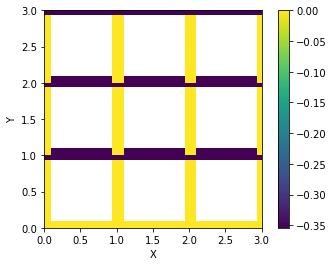

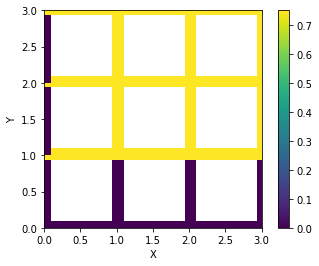

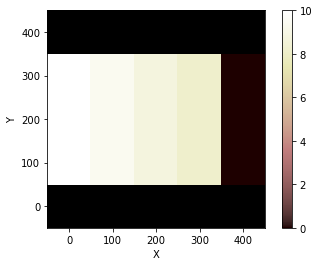

In [7]:
figure()
plot_links(mg, 'conduit__discharge')
figure()
plot_links(mg, 'hydraulic__diameter')
figure()
imshow_grid_at_node(mg, h)


In [15]:
FUDGE=0.0001
active_links = mg.active_links
head_nodes = mg.node_at_link_head[active_links]
tail_nodes = mg.node_at_link_tail[active_links]
h_head = mg.at_node['hydraulic__head'][head_nodes]
h_tail = mg.at_node['hydraulic__head'][tail_nodes]
#Calculate flow depths using offset and junction elevations
y_head = h_head - mg.at_node['junction__elevation'][head_nodes] \
         - mg.at_link['conduit_head__offset'][active_links]
y_tail = h_tail - mg.at_node['junction__elevation'][tail_nodes] \
          - mg.at_link['conduit_tail__offset'][active_links]
y_head[y_head>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_head>mg.at_link['maximum__depth'][active_links]]
y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
y_avg = 0.5*(y_head + y_tail)
A_avg = mg.at_link['width'][active_links] * y_avg
y_avg[y_avg<FUDGE] = FUDGE
A_avg[A_avg<FUDGE] = FUDGE

In [22]:
#y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = 
#mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
d_h_square(mg.at_link['width'][active_links], y_avg)

array([  3.96936126e-01,   3.53636005e-04,   3.99594057e-04,
         3.99687423e-04,   3.99814040e-04,   3.99715864e-04,
         3.99694894e-04,   4.90132384e-01,   3.99793756e-04,
         3.96927434e-04,   3.99777355e-04,   3.99802869e-04,
         3.99787176e-04,   3.97200621e-04,   2.81319838e-01,
         3.99646193e-04,   3.99446218e-04,   3.99054260e-04])

In [21]:
def d_h_square(width, flow_depth):
    d_H = np.zeros(np.size(width))
    is_full_pipe = np.isclose(width,flow_depth)
    d_H[is_full_pipe] = width[is_full_pipe]
    d_H[~is_full_pipe] = 4.*width[~is_full_pipe]*flow_depth[~is_full_pipe] / (2.*flow_depth[~is_full_pipe] + width[~is_full_pipe])
    return d_H

In [10]:
mg.at_link['hydraulic__diameter']

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.75,  0.75,  0.75,  0.5 ,  0.  ,  0.75,  0.75,  0.75,  0.  ,
        0.75,  0.75,  0.75,  0.5 ,  0.  ,  0.75,  0.75,  0.75,  0.  ,
        0.75,  0.75,  0.75,  0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ])

In [11]:
pfn.run_one_step()

Number of iterations = 1 tolerance = nan  iteration time= 0.016219377517700195


/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:186: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:267: RuntimeWarning: divide by zero encountered in double_scalars
  ADA_ij[i][j] = -1./(a[this_link]*r[this_link]*np.fabs(self.Q[this_link])**(a[this_link]-1))
/home/mcoving/anaconda3/envs/landlab_dev/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:277: RuntimeWarning: divide by zero encountered in true_divide
  dQ= -(1./a[self.grid.active_links])*self.Q[self.grid.active_links] - 1./(a[self.grid.active_links]*r[self.grid.active_links]*np.fabs(self.Q[self.grid.active_links])**(a[self.grid.active_link

In [5]:
d_h.copy()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])